<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd

In [535]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

def preprocess_and_train_model(matched_data):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    # Model Definition
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')  # Adjust output layer according to your needs
        ])
        return model

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)

    # Predictions and Evaluation
    predictions = model.predict(X_test).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y_test
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    r_squared = r2_score(inversed_truth, inversed_predictions)

    return model, test_loss, r_squared, inversed_predictions, scaler

# Use the function with your DataFrame
# model, test_loss, r_squared, predictions = preprocess_and_train_model(your_dataframe)


In [559]:
def predict_on_reserve(matched_data,model,scaler):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    # Predictions and Evaluation
    predictions = model.predict(X).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    matched_data['inversed_predictions'] = inversed_predictions.flatten()
    matched_data['inversed_imp_c'] =inversed_truth.flatten()
    return matched_data

In [4]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [5]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [6]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [147]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [240]:


# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [386]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [526]:
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


27/27 [==============================] - 0s 3ms/step


<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [561]:
predictions.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'c_perc',
       'imp_c', 'bulk_density', 'imp_bd', 'hole_id', 'geometry', 'index_right',
       'id', 'left', 'top', 'right', 'bottom', 'water', 'trees', 'grass',
       'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare',
       'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI', 'aet',
       'def', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx',
       'vap', 'vpd', 'vs', 'agbd_m', 'agbd_sd', 'agbd_n', 'majorcomposition',
       'age_years', 'age_class', 'distance', 'imp_c_float',
       'inversed_predictions', 'inversed_imp_c'],
      dtype='object')

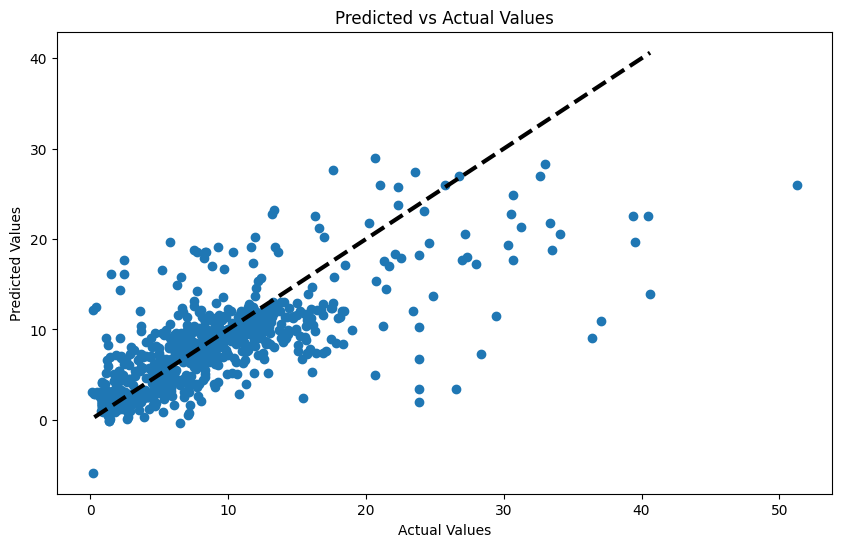

In [564]:
import matplotlib.pyplot as plt

# Make predictions on the test set
# predictions = model.predict(X_test).flatten()

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions['inversed_imp_c'], predictions['inversed_predictions'] )
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([inversed_truth.min(), inversed_truth.max()], [inversed_truth.min(), inversed_truth.max()], 'k--', lw=3)  # Diagonal line
plt.show()

In [565]:
# Use the function with your DataFrame
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)

predictions_a = predict_on_reserve(reserve_data,model,scaler)

27/27 [==============================] - 0s 3ms/step


<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [570]:
predictions_b = predict_on_reserve(reserve_data,model,scaler)

27/27 [==============================] - 0s 4ms/step


<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [591]:
predictions_b

,source_dataset,island,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,c_perc,...,agbd_m,agbd_sd,agbd_n,majorcomposition,age_years,age_class,distance,imp_c_float,inversed_predictions,inversed_imp_c
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,65.050623,38.345193,7.0,Alkalic Basalt,300000.0,Holocene,0,4.190000,5.809844,4.190000
100,FIA,Oahu,FIA_1433,FIA101,0,20,20,21.475448,-157.984458,4.236,...,136.620069,189.200505,2.0,Hawaiite,1300000.0,Holocene,0,4.236000,2.916269,4.236000
105,FIA,Oahu,FIA_1454,FIA106,0,20,20,21.419936,-157.906723,9.24,...,103.596687,74.681287,17.0,Tholeiitic Basalt,3000.0,Pre-Holocene,0,9.240000,6.628251,9.240000
10,FIA,Kauai,FIA_1077,FIA11,0,20,20,22.152306,-159.380618,6.46,...,NaN,NaN,0.0,Tholeiitic Basalt,400.0,Pre-Holocene,0,6.460000,11.236103,6.460000
110,FIA,Oahu,FIA_1457,FIA111,0,20,20,21.404189,-157.854121,2.62,...,24.482756,NaN,1.0,Tholeiitic Basalt,3000.0,Pre-Holocene,0,2.620000,2.680759,2.620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,SH,Oahu,SH946-01,SH946,0,15,20,21.69535727,-158.0021038,1.55,...,4.866883,2.353687,3.0,Tholeiitic Basalt,164.0,Pre-Holocene,0,1.461341,1.678277,1.461341
6849,SH,Oahu,SH947-01,SH947,0,15,20,21.69554769,-158.0021022,1.74,...,25.776136,31.113303,13.0,Tholeiitic Basalt,5000.0,Pre-Holocene,0,1.640473,2.370684,1.640473
6850,SH,Oahu,SH948-01,SH948,0,15,20,21.69571972,-158.0021121,1.7,...,94.659355,81.575676,13.0,Tholeiitic Basalt,1500.0,Pre-Holocene,0,1.602761,4.910816,1.602761
6851,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,76.633321,107.391023,9.0,Tholeiitic Basalt,5000.0,Pre-Holocene,0,1.772466,1.567377,1.772466


In [574]:
predictions_a['inversed_imp_c']

0       4.190000
100     4.236000
105     9.240000
10      6.460000
110     2.620000
          ...   
6848    1.461341
6849    1.640473
6850    1.602761
6851    1.772466
5999    6.929586
Name: inversed_imp_c, Length: 849, dtype: float64

In [578]:
# Use the function with your DataFrame
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


prediction_list = []

for i in range(10):
  matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, inversed_predictions, scaler = preprocess_and_train_model(matched_data)

  predictions = predict_on_reserve(reserve_data,model,scaler)
  prediction_list.append(predictions)


<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 72ms/step - loss: 2.4542 - val_loss: 0.0380
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 2.2641 - val_loss: 0.0321
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.4078 - val_loss: 0.0362
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 2.0300 - val_loss: 0.0333
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.7667 - val_loss: 0.0401
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.8335 - val_loss: 0.0431
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 1.8741 - val_loss: 0.0346
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.2507 - val_loss: 0.0323
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 1.1426 - val_loss: 0.0346
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3457 - val_loss: 0.0322
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 67ms/step - loss: 1.7831 - val_loss: 0.0321
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8260 - val_loss: 0.0236
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 1.7565 - val_loss: 0.0207
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 2.8972 - val_loss: 0.0249
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 2.1870 - val_loss: 0.0344
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.5718 - val_loss: 0.0362
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 1.6306 - val_loss: 0.0397
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.7023 - val_loss: 0.0357
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 1.2979 - val_loss: 0.0341
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 1.0786 - val_loss: 0.0351
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 71ms/step - loss: 2.5037 - val_loss: 0.0210
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 2.1266 - val_loss: 0.0259
Epoch 3/100
5/5 [==============================] - 0s 23ms/step - loss: 2.2373 - val_loss: 0.0241
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7701 - val_loss: 0.0248
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7776 - val_loss: 0.0279
Epoch 6/100
5/5 [==============================] - 0s 24ms/step - loss: 1.7517 - val_loss: 0.0290
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 1.7918 - val_loss: 0.0311
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.6957 - val_loss: 0.0320
Epoch 9/100
5/5 [==============================] - 0s 23ms/step - loss: 1.5483 - val_loss: 0.0335
Epoch 10/100
5/5 [==============================] - 0s 22ms/step - loss: 1.5741 - val_loss: 0.0295
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 71ms/step - loss: 2.3528 - val_loss: 0.0270
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 2.1469 - val_loss: 0.0395
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.0301 - val_loss: 0.0349
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7912 - val_loss: 0.0392
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6081 - val_loss: 0.0409
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9498 - val_loss: 0.0397
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.7052 - val_loss: 0.0387
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.5128 - val_loss: 0.0362
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6302 - val_loss: 0.0384
Epoch 10/100
5/5 [==============================] - 0s 21ms/step - loss: 1.6982 - val_loss: 0.0383
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 68ms/step - loss: 2.2207 - val_loss: 0.0377
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 3.3243 - val_loss: 0.0232
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 2.4062 - val_loss: 0.0616
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9542 - val_loss: 0.0473
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.9600 - val_loss: 0.0331
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7988 - val_loss: 0.0373
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4721 - val_loss: 0.0381
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4469 - val_loss: 0.0367
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.1064 - val_loss: 0.0383
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.1399 - val_loss: 0.0367
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 73ms/step - loss: 2.1539 - val_loss: 0.0169
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 1.9499 - val_loss: 0.0321
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 2.5078 - val_loss: 0.0250
Epoch 4/100
5/5 [==============================] - 0s 21ms/step - loss: 2.2335 - val_loss: 0.0248
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 2.2359 - val_loss: 0.0253
Epoch 6/100
5/5 [==============================] - 0s 21ms/step - loss: 2.0705 - val_loss: 0.0321
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3608 - val_loss: 0.0327
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3889 - val_loss: 0.0305
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4259 - val_loss: 0.0322
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.0688 - val_loss: 0.0336
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 70ms/step - loss: 2.0599 - val_loss: 0.0551
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 2.6427 - val_loss: 0.0285
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9743 - val_loss: 0.0364
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 1.9891 - val_loss: 0.0418
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 1.9445 - val_loss: 0.0401
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6151 - val_loss: 0.0467
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.5022 - val_loss: 0.0406
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.1050 - val_loss: 0.0437
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4797 - val_loss: 0.0425
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 0.9167 - val_loss: 0.0391
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 70ms/step - loss: 2.3635 - val_loss: 0.0903
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 2.3199 - val_loss: 0.0480
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 1.8661 - val_loss: 0.0526
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 1.6256 - val_loss: 0.0516
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 1.6833 - val_loss: 0.0577
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7762 - val_loss: 0.0410
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.3710 - val_loss: 0.0387
Epoch 8/100
5/5 [==============================] - 0s 21ms/step - loss: 1.4785 - val_loss: 0.0429
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 1.2669 - val_loss: 0.0416
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 1.2866 - val_loss: 0.0441
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 68ms/step - loss: 2.3934 - val_loss: 0.0402
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 2.2224 - val_loss: 0.0420
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 2.4276 - val_loss: 0.0450
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 2.2548 - val_loss: 0.0507
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 2.9746 - val_loss: 0.0413
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.5101 - val_loss: 0.0366
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 1.8032 - val_loss: 0.0421
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.0373 - val_loss: 0.0421
Epoch 9/100
5/5 [==============================] - 0s 22ms/step - loss: 1.5103 - val_loss: 0.0427
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 1.5370 - val_loss: 0.0393
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-535-352fa283bc47>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 66ms/step - loss: 2.5086 - val_loss: 0.0784
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 1.9577 - val_loss: 0.0299
Epoch 3/100
5/5 [==============================] - 0s 20ms/step - loss: 1.9771 - val_loss: 0.0341
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 1.9039 - val_loss: 0.0444
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3713 - val_loss: 0.0409
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.8790 - val_loss: 0.0408
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4314 - val_loss: 0.0410
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 1.6465 - val_loss: 0.0480
Epoch 9/100
5/5 [==============================] - 0s 22ms/step - loss: 1.4707 - val_loss: 0.0425
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4438 - val_loss: 0.0416
Epoch 11/100
5/5 [=

<ipython-input-559-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [592]:
combined_array = np.array([predictions['inversed_predictions'].values for predictions in prediction_list])

In [622]:
combined_array.shape[1]

849

In [624]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
dist_array

[array([2.50915633, 2.61886693, 2.74805991, 2.75024367, 2.76310353,
        2.98718066, 3.12770775, 3.42537245, 3.44053513, 4.76742038]),
 array([0.22795147, 0.96432956, 1.80971395, 1.81116198, 1.87294547,
        2.34658513, 2.43556571, 2.62813195, 2.63955883, 2.95144913]),
 array([ 2.99245822,  3.10235875,  4.86733957,  4.98890016,  5.02389596,
         5.09938858,  6.04853485,  7.61071683, 10.36419314, 11.80946896]),
 array([2.739274  , 2.76196888, 2.86129885, 3.84345127, 4.65955026,
        4.98751557, 5.99631281, 6.08298428, 6.34352257, 6.97945129]),
 array([ 3.0572837 ,  3.0589752 ,  4.37478161,  4.64479296,  4.70963025,
         5.23874082,  7.94766255, 10.30928269, 10.44680837, 14.34985839]),
 array([ 0.80790901,  1.41050676,  2.67686127,  3.5023674 ,  5.64668706,
         5.84815694,  6.22057473,  6.68598189,  8.13146803, 11.99302602]),
 array([-1.54167235,  0.32255691,  0.50335964,  1.30695596,  2.97207703,
         8.01876441,  9.9609059 , 10.45652947, 11.52216888, 15.785700

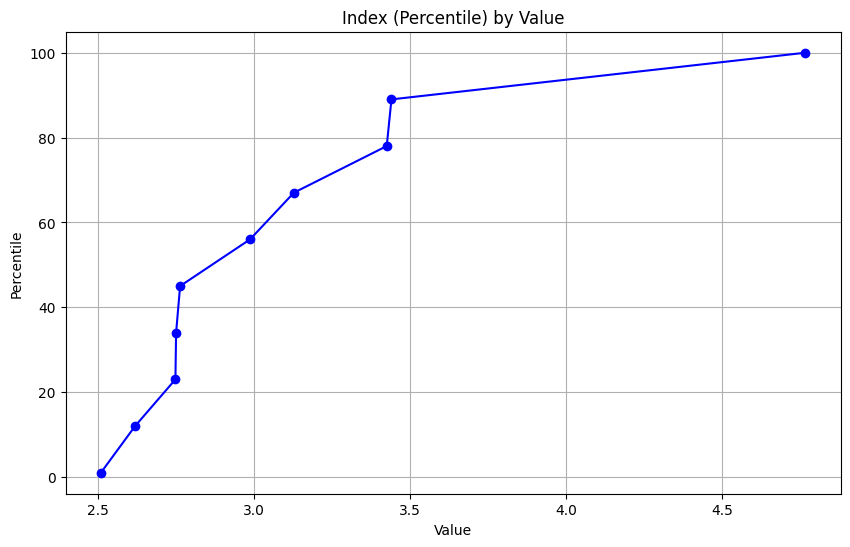

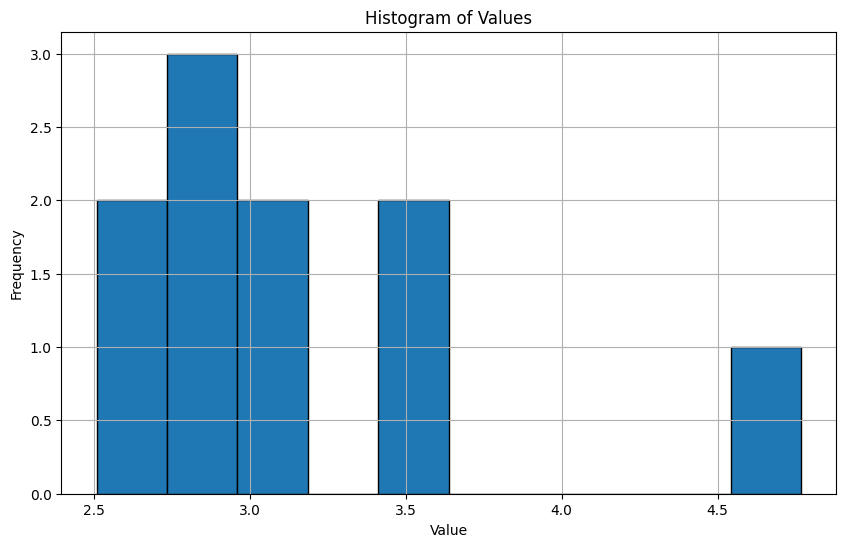

In [625]:
array = dist_array[0]
# Generating y values as indices (percentiles in this context)
y_values = np.linspace(1, 100, len(array))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(array, y_values, marker='o', linestyle='-', color='b')
plt.title('Index (Percentile) by Value')
plt.xlabel('Value')
plt.ylabel('Percentile')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(array, bins=len(array), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

